In [46]:
import torch
import tiktoken
from torch.nn import functional as F

In [47]:
computeDevice = torch.device("cpu")
if torch.cuda.is_available():
    computeDevice = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    computeDevice = torch.device("mps")
    
print(f"Using Compute Device: {computeDevice}")

torch.set_float32_matmul_precision("high")

Using Compute Device: mps


In [48]:
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

print(len(text))
trainText = text[:1000]
tokens = enc.encode(trainText)

B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1], device=computeDevice)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

print(x.shape)
print(y.shape) 

1115394
torch.Size([4, 32])
torch.Size([4, 32])


In [49]:
from train_gpt2 import GPT, GPTConfig
import sys

# model = GPT(GPTConfig(vocab_size=50304))
model = GPT.from_pretrained('gpt2')
model.to(computeDevice)

if sys.version_info.major == 3 and sys.version_info.minor < 12:
    model = torch.compile(model)
else:
    print(sys.version_info)
    print(f"Cannot compile pytorch model, skipping .....")

Loading weights from pretrained gpt: gpt2
sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
Cannot compile pytorch model, skipping .....


In [50]:
with torch.no_grad():
    logits, loss = model(x,y)
    print(logits.shape)
    print(loss)

torch.Size([4, 32, 50257])
tensor(5.1067, device='mps:0')


In [51]:
import math

# Cosine learning rate with warm up
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 50
# warmup_steps = 715
# max_steps = 19073

def get_lr(it):
    # 1 - Linear warmip for warmip_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps

    # 2 - If it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr

    # 3 - In between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

In [52]:
# Gradient Accumulation
total_batch_size = 4096 #524288 # 2^19 -> ~0.5M in number of tokens
B = 2 # micro batch size
T = 1024 # sequence length
assert total_batch_size % (B * T) == 0, "make sure `total_batch_size` is divisible by `(B * T)`"
grad_accum_steps = total_batch_size // (B*T)
print(f"Total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

Total desired batch size: 4096
=> calculated gradient accumulation steps: 2


In [53]:
from data_loader import DataLoaderFineWeb #DataLoaderLite
import time

torch.mps.empty_cache()
torch.manual_seed(1337)

# B, T = 16, 1024
# B, T = 4, 1024

dataset = DataLoaderFineWeb(B, T, split="train")
val_loader = DataLoaderFineWeb(B, T, split="val")
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=computeDevice)

losses = []
val_losses = []
learn_rates = []
for step in range(max_steps):
    t0 = time.time()

    # once in a while evaluate our validation loss
    if step % 5 == 0:
        model.eval()
        val_loader.reset()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 20
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(computeDevice), y.to(computeDevice)
                if torch.cuda.is_available():
                    with torch.autocast(device_type=computeDevice, dtype=torch.bfloat16):
                        logits, loss = model(x, y)
                else:
                    logits, loss = model(x, y)
                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()
            print(f"Validation loss: {val_loss_accum.item():.4f}")
            val_losses.append(val_loss_accum.item())

    # training mode
    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0

    for micro_step in range(grad_accum_steps):
        x, y = dataset.next_batch()
        x, y = x.to(computeDevice), y.to(computeDevice)

        if torch.cuda.is_available():
            with torch.autocast(device_type=computeDevice, dtype=torch.bfloat16):
                logits, loss = model(x, y)
        else:
            logits, loss = model(x, y)
        loss = loss / grad_accum_steps # normalize by the number of accumulation steps
        loss_accum += loss.detach()
        loss.backward()

    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(step)
    learn_rates.append(lr)
    for param_group in optimizer.param_groups:
        param_group[lr] = lr
    optimizer.step()

    t1 = time.time()
    dt = t1 - t0 # time difference in seconds
    tokens_processed = dataset.B * dataset.T * grad_accum_steps
    tokens_per_sec = tokens_processed / dt

    print(f"Step {step:4d} | loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
    losses.append(loss.item())


num decayed parameter tensors: 50, with 124,318,464 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
Using fused AdamW: False, inspect check: True
Validation loss: 3.2212
Step    0 | loss: 3.389941 | lr: 6.0000e-05 | norm: 13.1464 | dt: 11872.30ms | tok/sec: 345.00
Step    1 | loss: 4.430582 | lr: 1.2000e-04 | norm: 65.9015 | dt: 2934.96ms | tok/sec: 1395.59
Step    2 | loss: 3.665580 | lr: 1.8000e-04 | norm: 15.2324 | dt: 2913.39ms | tok/sec: 1405.92
Step    3 | loss: 3.486974 | lr: 2.4000e-04 | norm: 19.9974 | dt: 2941.22ms | tok/sec: 1392.62
Step    4 | loss: 3.837164 | lr: 3.0000e-04 | norm: 15.3505 | dt: 2925.91ms | tok/sec: 1399.91
Validation loss: 3.6802
Step    5 | loss: 3.776669 | lr: 3.6000e-04 | norm: 12.5154 | dt: 11546.94ms | tok/sec: 354.73
Step    6 | loss: 3.696328 | lr: 4.2000e-04 | norm: 9.9544 | dt: 2911.84ms | tok/sec: 1406.67
Step    7 | loss: 3.673552 | lr: 4.8000e-04 | norm: 7.5338 | dt: 2917.62ms | tok/sec: 1403.88
Step    8 | loss: 3.70

Text(0.5, 1.0, 'Validation Losses')

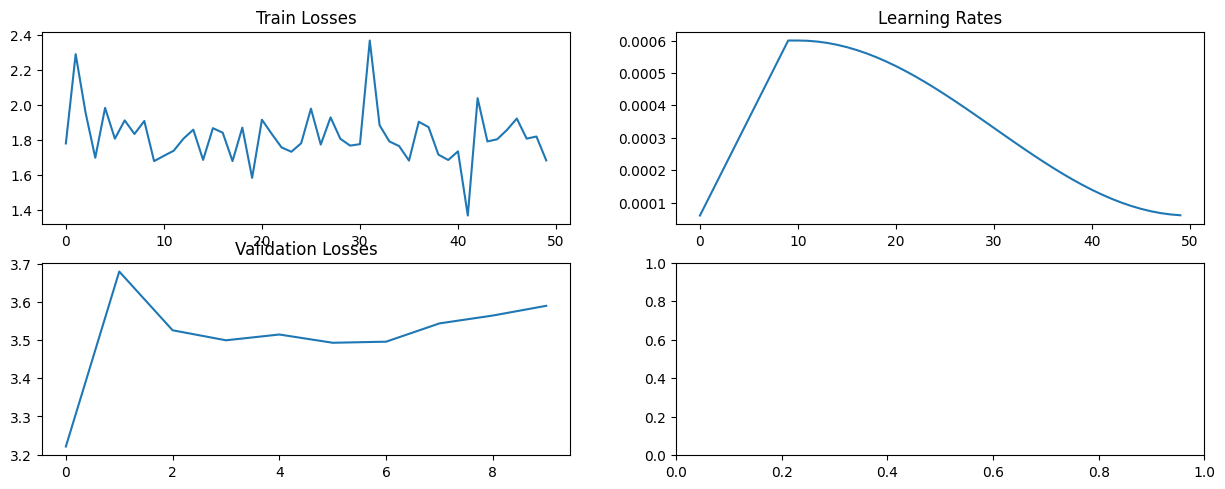

In [54]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(5.5)

axs[0,0].plot(losses)
axs[0,0].set_title("Train Losses")
axs[0,1].plot(learn_rates)
axs[0,1].set_title("Learning Rates")
axs[1,0].plot(val_losses)
axs[1,0].set_title("Validation Losses")

In [55]:
torch.mps.empty_cache() #GPUPoor

evalText = text[1000:]
evalData = enc.encode(evalText)
B, maxT = 8, 512

x = torch.tensor(evalData[:B * maxT], device=computeDevice)
x = x.view(B, maxT)

# evalText = "Second Citizen:\nWould you proceed especially against Caius Marcius?"
# evalData = enc.encode(evalText)
# x = torch.tensor(evalData, device=computeDevice)
# x = x.view(1, -1)

with torch.no_grad():
    logits, loss = model(x)
    logits = logits[:,-1,:]
    probs = F.softmax(logits, dim=-1)
    # do top-k sampling of 50
    topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
    ix = torch.multinomial(topk_probs, 1) # (B,1)
    xcol = torch.gather(topk_indices, -1, ix)
    x = torch.cat((x, xcol), dim=1)

In [56]:
print(enc.decode(x[0,:-1].tolist()))
print("***" * 10)
for i in range(x.size(0)):
    print("--")
    print(enc.decode([x[i,-1].tolist()]))

Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the commonalty.

Second Citizen:
Consider you what services he has done for his country?

First Citizen:
Very well; and could be content to give him good
report fort, but that he pays himself with being proud.

Second Citizen:
Nay, but speak not maliciously.

First Citizen:
I say unto you, what he hath done famously, he did
it to that end: though soft-conscienced men can be
content to say it was for his country he did it to
please his mother and to be partly proud; which he
is, even till the altitude of his virtue.

Second Citizen:
What he cannot help in his nature, you account a
vice in him. You must in no way say he is covetous.

First Citizen:
If I must not, I need not be barren of accusations;
he hath faults, with surplus, to tire in repetition.
What shouts are these? The other side o' the city
is risen: why stay we prating here? to the Capitol!

All:
Come, come.

First C